In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.stats import spearmanr
import seaborn as sns
# import tqdm

In [2]:
File_name = '12859_2019_2897_MOESM2_ESM.xlsx'

sheet_names = pd.ExcelFile(File_name).sheet_names
sheets = {}
for sheet in sheet_names:
    sheets[sheet] = pd.read_excel(File_name,sheet_name=sheet,index_col=0)
#load the graphs into a dictionary
graphs = {}
for sheet in sheet_names:
    graphs[sheet] = nx.from_pandas_adjacency(sheets[sheet],create_using=nx.DiGraph)

In [3]:
import cobra
from cobra.io import read_sbml_model
from pathlib import Path
import os

#Fixing typo in supplimentary table from the paper
index = sheet_names.index("E.coli (iJ01366)")
sheet_names[index] = "E.coli (iJO1366)"


Micro_models = {}
for sheet in sheet_names:
    model_name = sheet.split('(')[1].split(')')[0]
    model_path = Path('Data/'+model_name+'.xml')
    if os.path.isfile(model_path):
        Micro_models[sheet] = read_sbml_model(str(model_path))
    else:
        print(f"File {model_path} does not exist.")


#change the name of the first graph
graphs["E.coli (iJO1366)"] = graphs.pop("E.coli (iJ01366)")

In [4]:
# add cob(i)alamin to allowed nutrients list
# what does the prefix EX mean, shouldn't we use prefix M?
allowed_nutrients = ['EX_ca2_e', 'EX_cl_e', 'EX_co2_e', 'EX_cobalt2_e', 'EX_cu2_e', 'EX_fe2_e', 'EX_fe3_e', 'EX_glc__D_e', 'EX_h_e', 'EX_h2o_e', 'EX_h_e', 'EX_k_e', 'EX_mg2_e', 'EX_mn2_e', 'EX_mqn8_e', 'EX_na1_e', 'EX_nh4_e', 'EX_ni2_e', 'EX_o2_e', 'EX_sel_e', 'EX_slnt_e', 'EX_so4_e', 'EX_tungs_e', 'EX_zn2_e']
allowed_nutrients.append('EX_cbl1_e')
# allowed_nutrients=[i.replace("EX", "M") for i in allowed_nutrients]
len(allowed_nutrients)

25

In [5]:
## functions:
def get_lofo(ecoli_model, ecoli_graph):
    fba_ecoli_lofo = {}
    reactions = [rxn.strip() for rxn in ecoli_graph.nodes()]
    for rxn in reactions:
        if rxn not in ecoli_model.reactions:
            if rxn.endswith('i') or rxn.endswith('r'):
                rxn = rxn[:-1]
        if rxn in ecoli_model.reactions:
            rxn_df = ecoli_model.reactions.get_by_id(rxn)
            old_bounds = rxn_df.bounds
            rxn_df.knock_out()
            solution = ecoli_model.optimize()
            fba_ecoli_lofo[rxn] = solution.objective_value
            rxn_df.bounds = old_bounds
    return fba_ecoli_lofo

def get_threshold(model):
    solution = model.optimize()
    threshold = (solution.objective_value)/20
    return threshold

def get_essential_reactions(lofo, threshold):
    Essential_reactions = []
    for rxn in lofo:
        if lofo[rxn] < threshold:
            Essential_reactions.append(rxn)
    return Essential_reactions


# def get_bridging_centrality_log10(model_graph_df):
#     # Calculate betweenness centrality
#     betweenness = nx.betweenness_centrality(model_graph_df, weight='weight', normalized=False)

#     # Calculate the bridging coefficient for each node
#     bridging_coefficient = {}
#     for node in model_graph_df.nodes():
#         # For directed graphs, consider successors and predecessors
#         if model_graph_df.is_directed():
#             successors = list(model_graph_df.successors(node))
#             predecessors = list(model_graph_df.predecessors(node))
#             degree_sum = sum(model_graph_df.out_degree(successor) for successor in successors) + \
#                          sum(model_graph_df.in_degree(predecessor) for predecessor in predecessors)
#         else:
#             # For undirected graphs, consider neighbors
#             neighbors = list(model_graph_df.neighbors(node))
#             degree_sum = sum(model_graph_df.degree(neighbor) for neighbor in neighbors)

#         bridging_coefficient[node] = 1 / degree_sum if degree_sum > 0 else 0

#     # Calculate bridging centrality
#     bridging_centrality = {node: betweenness[node] * bridging_coefficient[node] for node in model_graph_df.nodes()}

#     # Extract values and apply log10 transformation
#     bridging_centrality_values = list(bridging_centrality.values())
#     log10_bridging_centrality_values = [np.log10(value + 1) for value in bridging_centrality_values]

#     return log10_bridging_centrality_values

# def get_betweenness_centrality_log10(model_graph_df):
#     model_betweenness_centrality = nx.betweenness_centrality(model_graph_df, weight='weight', normalized=False)
#     betweenness_centrality_values = list(model_betweenness_centrality.values())
#     model_betweenness_centrality = {key.strip(): value for key, value in model_betweenness_centrality.items()}
#     log10_unique_centrality_values = [np.log10(value + 1) for value in betweenness_centrality_values]
#     return log10_unique_centrality_values

# def get_clustering_coefficient(model_graph_df):
#     model_clustering_coefficient = nx.clustering(model_graph_df)
#     clustering_coefficient_values = list(model_clustering_coefficient.values())
#     model_clustering_coefficient = {key.strip(): value for key, value in model_clustering_coefficient.items()}
#     return clustering_coefficient_values

# def get_degree(model_graph_df):
#     model_degree = dict(model_graph_df.degree())
#     model_degree = {key.strip(): value for key, value in model_degree.items()}
#     log10_unique_degree_values = [np.log10(value + 1) for value in model_degree.values()]
#     return log10_unique_degree_values


In [6]:
def get_betweenness_centrality_log10(model_graph_df):
    # Calculate betweenness centrality
    model_betweenness_centrality = nx.betweenness_centrality(model_graph_df, weight='weight', normalized=False)
    
    # Strip whitespace from keys and log-transform the values
    log10_betweenness_centrality = {key.strip(): np.log10(value + 1) for key, value in model_betweenness_centrality.items()}
    
    return log10_betweenness_centrality


def get_bridging_centrality_log10(model_graph_df):
    # Calculate betweenness centrality
    betweenness = nx.betweenness_centrality(model_graph_df, weight='weight', normalized=False)

    # Calculate the bridging coefficient for each node
    bridging_coefficient = {}
    for node in model_graph_df.nodes():
        # For directed graphs, consider successors and predecessors
        if model_graph_df.is_directed():
            successors = list(model_graph_df.successors(node))
            predecessors = list(model_graph_df.predecessors(node))
            degree_sum = sum(model_graph_df.out_degree(successor) for successor in successors) + \
                         sum(model_graph_df.in_degree(predecessor) for predecessor in predecessors)
        else:
            # For undirected graphs, consider neighbors
            neighbors = list(model_graph_df.neighbors(node))
            degree_sum = sum(model_graph_df.degree(neighbor) for neighbor in neighbors)

        bridging_coefficient[node] = 1 / degree_sum if degree_sum > 0 else 0

    # Calculate bridging centrality
    bridging_centrality = {node: betweenness[node] * bridging_coefficient[node] for node in model_graph_df.nodes()}

    # Strip whitespace from keys and log-transform the values
    log10_bridging_centrality = {key.strip(): np.log10(value + 1) for key, value in bridging_centrality.items()}

    return log10_bridging_centrality

def get_clustering_coefficient(model_graph_df):
    model_clustering_coefficient = nx.clustering(model_graph_df)

    # Strip whitespace from keys and log-transform the values
    clustering_coefficient = {key.strip(): value for key, value in model_clustering_coefficient.items()}

    return clustering_coefficient

def get_degree(model_graph_df):
    model_degree = dict(model_graph_df.degree())

    # Strip whitespace from keys and log-transform the values
    log10_degree = {key.strip(): np.log10(value + 1) for key, value in model_degree.items()}

    return log10_degree


In [13]:
# Assuming all previous function definitions are correct and Micro_models is a dictionary of models.
model_names = list(Micro_models.keys())

# Let's get the figure for the first model
model_name = model_names[0]
model = Micro_models[model_name]
model_graph_df = graphs[model_name]

# Generate LOFO and threshold
model_lofo = get_lofo(model, model_graph_df)
threshold = get_threshold(model)

# Get essential reactions
Essential_reactions = get_essential_reactions(model_lofo, threshold)

# Get log10-transformed betweenness centrality values
log10_betweenness_dict = get_betweenness_centrality_log10(model_graph_df)

# We need the values for the histogram
log10_betweenness_values = list(log10_betweenness_dict.values())

# Calculate bins based on the log10-transformed values
bins = np.linspace(min(log10_betweenness_values), max(log10_betweenness_values), num=11)
hist_data, bin_edges = np.histogram(log10_betweenness_values, bins=bins)

# Calculate the essential reactions percentage
essential_reactions_percentage = []
for bin_start, bin_end in zip(bin_edges[:-1], bin_edges[1:]):
    # Find reactions within this bin
    in_bin = [reaction for reaction, value in log10_betweenness_dict.items() if bin_start <= value < bin_end]
    # Count how many of these are essential
    essential_in_bin = sum(reaction in Essential_reactions for reaction in in_bin)
    # Calculate percentage
    total_in_bin = len(in_bin)
    percentage = (essential_in_bin / total_in_bin * 100) if total_in_bin > 0 else 0
    essential_reactions_percentage.append(percentage)

# Now you can use the essential_reactions_percentage and hist_data to plot your histogram and scatter plot.


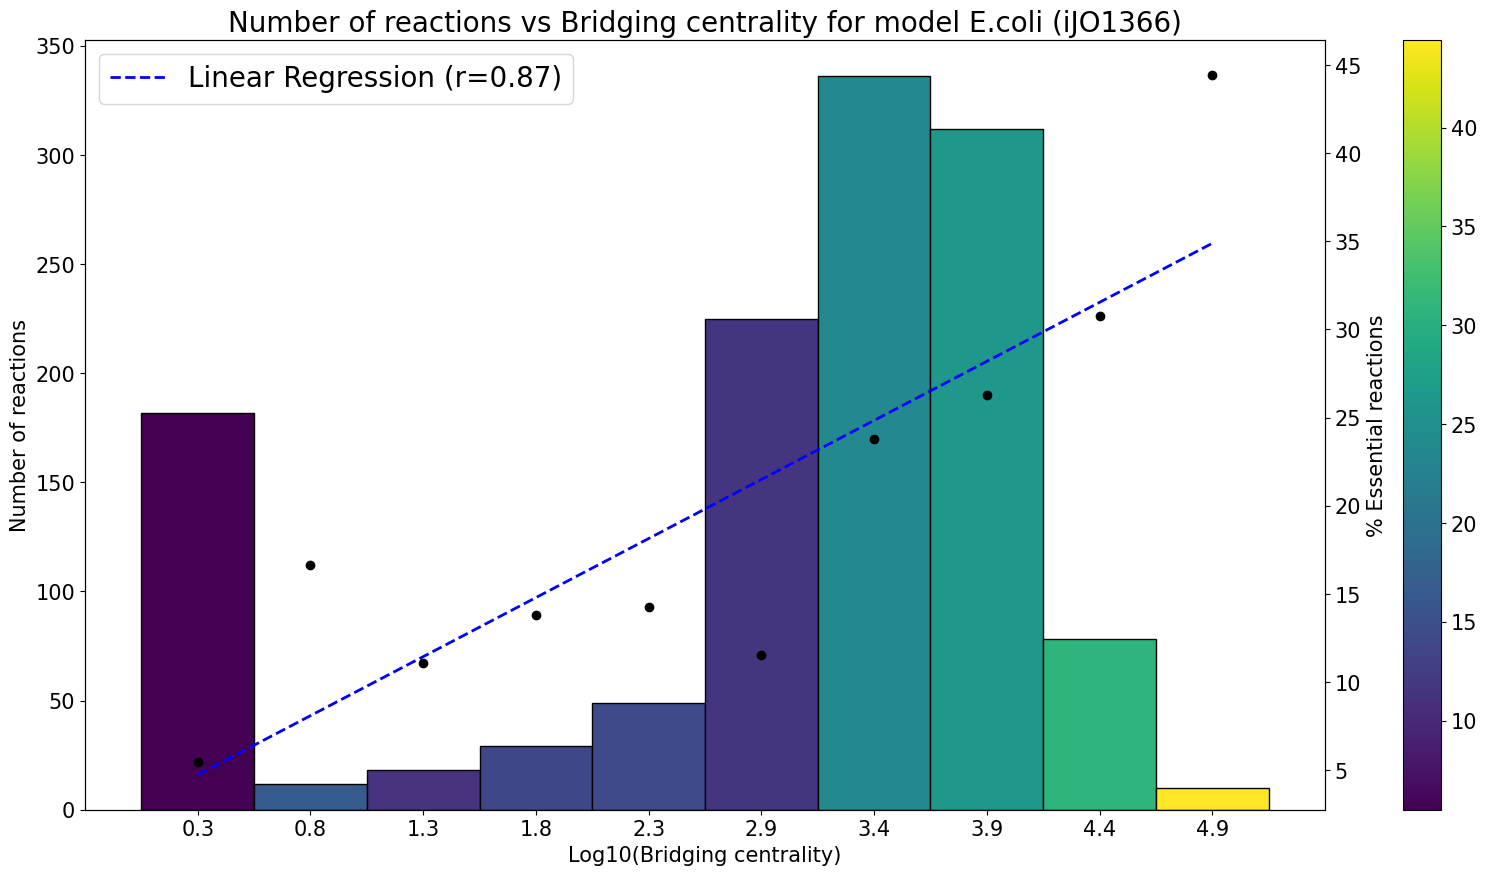

In [14]:
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Define a colormap
cmap = plt.cm.viridis
# Normalize the essential reactions percentage to the range [0, 1]
norm = plt.Normalize(min(essential_reactions_percentage), max(essential_reactions_percentage))
# Map the normalized percentage to the colormap
colors = cmap(norm(essential_reactions_percentage))

# Plotting
fig, ax1 = plt.subplots(figsize=(20, 10))
ax1.bar(bin_edges[:-1], hist_data, width=np.diff(bin_edges), color=colors, edgecolor='black', align='edge')

# Create secondary axis for essential reactions percentage
ax2 = ax1.twinx()
ax2.scatter(bin_centers, essential_reactions_percentage, color='black', zorder=5)

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(bin_centers, essential_reactions_percentage)
x_reg_values = np.linspace(min(bin_centers), max(bin_centers), 100)
y_reg_values = slope * x_reg_values + intercept

# Plot the regression line
ax2.plot(x_reg_values, y_reg_values, color='blue', linestyle='--', linewidth=2, label=f'Linear Regression (r={r_value:.2f})')

# Set labels and title
ax1.set_xlabel('Log10(Bridging centrality)')
ax1.set_ylabel('Number of reactions', color='black')
ax2.set_ylabel('% Essential reactions', color='black')
ax1.set_title('Number of reactions vs Bridging centrality for model ' + model_name, fontsize=20)

# Add legend for the regression line
ax2.legend(loc='upper left', fontsize=20)

# Set x-ticks to bin centers
ax1.set_xticks(bin_centers)
ax1.set_xticklabels([f"{center:.1f}" for center in bin_centers])

# Add colorbar for the percentage of essential reactions
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax1, orientation='vertical')

# Update plot aesthetics
plt.rcParams.update({'font.size': 15})

plt.show()

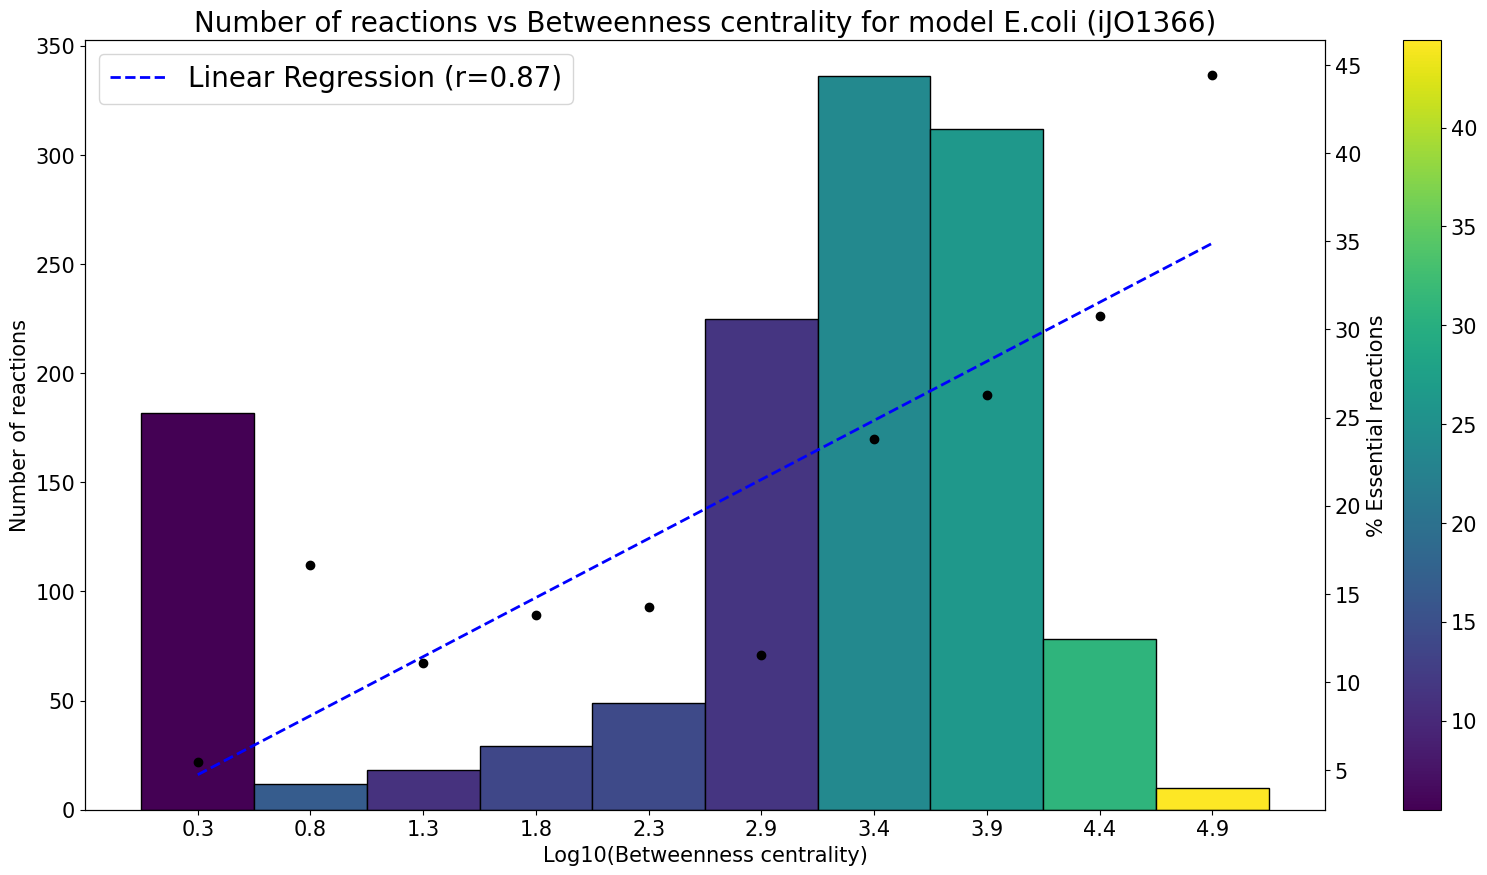

In [15]:
# now lets run the functions for betweeness centrality, bridging centrality, clustering coefficient and degree
# and plot each one
# betweenness centrality
betweenness_centrality_log10 = get_betweenness_centrality_log10(model_graph_df)
betweenness_centrality_log10_values = list(betweenness_centrality_log10.values())

bins = np.linspace(min(betweenness_centrality_log10_values), max(betweenness_centrality_log10_values), num=11)
hist_data, bin_edges = np.histogram(betweenness_centrality_log10_values, bins=bins)
essential_reactions_percentage = []
for bin_start, bin_end in zip(bin_edges[:-1], bin_edges[1:]):
    # Find reactions within this bin
    in_bin = [reaction for reaction, value in betweenness_centrality_log10.items() if bin_start <= value < bin_end]
    # Count how many of these are essential
    essential_in_bin = sum(reaction in Essential_reactions for reaction in in_bin)
    # Calculate percentage
    total_in_bin = len(in_bin)
    percentage = (essential_in_bin / total_in_bin * 100) if total_in_bin > 0 else 0
    essential_reactions_percentage.append(percentage)

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
fig, ax1 = plt.subplots(figsize=(20, 10))
ax1.bar(bin_edges[:-1], hist_data, width=np.diff(bin_edges), color=colors, edgecolor='black', align='edge')
ax2 = ax1.twinx()
ax2.scatter(bin_centers, essential_reactions_percentage, color='black', zorder=5)
slope, intercept, r_value, p_value, std_err = linregress(bin_centers, essential_reactions_percentage)
x_reg_values = np.linspace(min(bin_centers), max(bin_centers), 100)
y_reg_values = slope * x_reg_values + intercept
ax2.plot(x_reg_values, y_reg_values, color='blue', linestyle='--', linewidth=2, label=f'Linear Regression (r={r_value:.2f})')
ax1.set_xlabel('Log10(Betweenness centrality)')
ax1.set_ylabel('Number of reactions', color='black')
ax2.set_ylabel('% Essential reactions', color='black')
ax1.set_title('Number of reactions vs Betweenness centrality for model ' + model_name, fontsize=20)
ax2.legend(loc='upper left', fontsize=20)
ax1.set_xticks(bin_centers)
ax1.set_xticklabels([f"{center:.1f}" for center in bin_centers])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax1, orientation='vertical')
plt.rcParams.update({'font.size': 15})
plt.show()


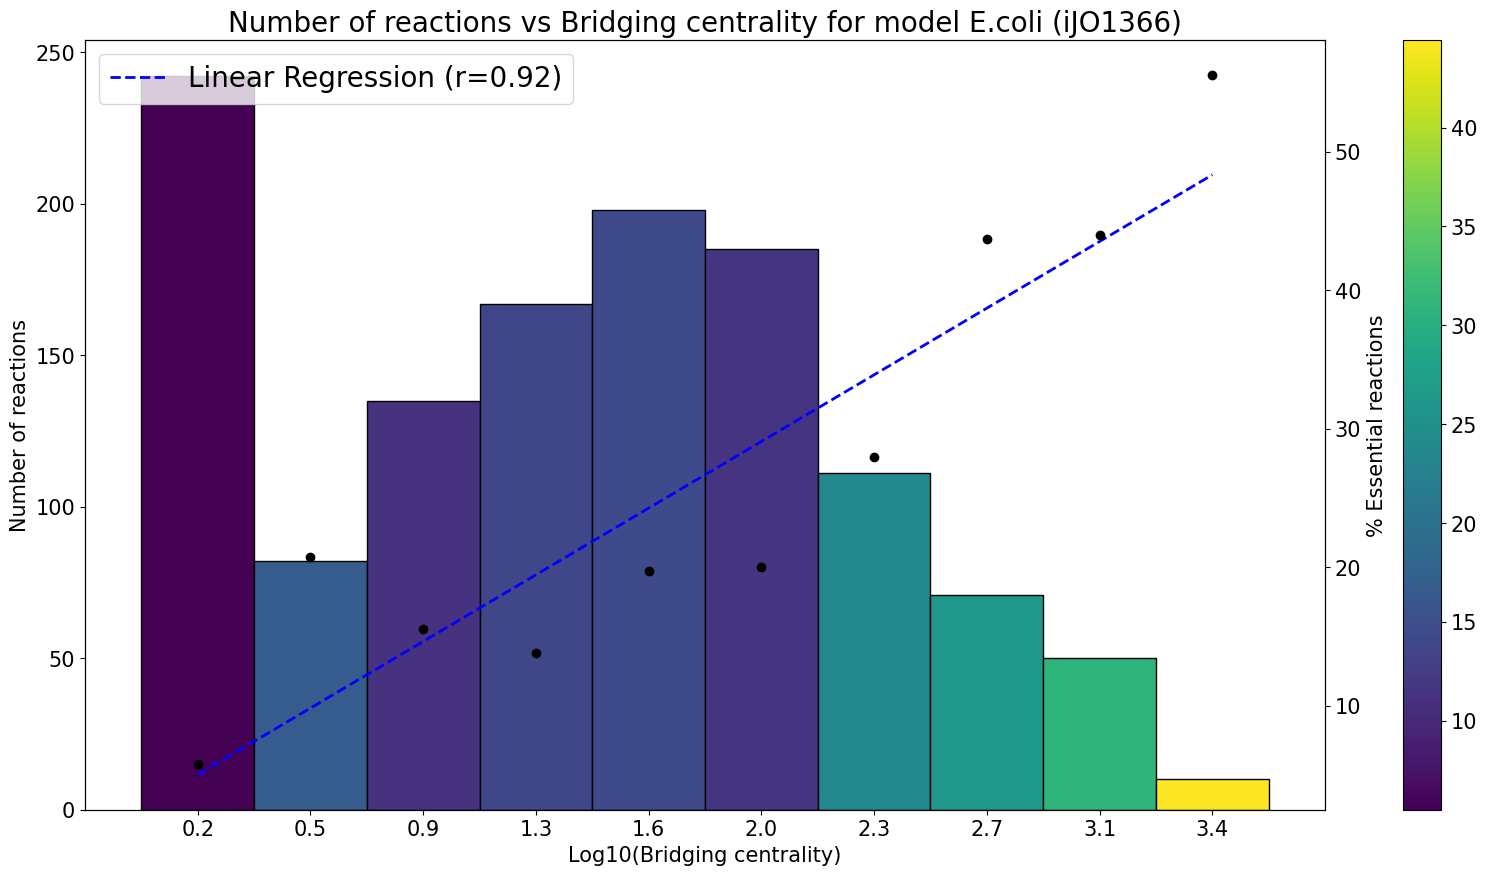

In [16]:
#bridging centrality
bridging_centrality_log10 = get_bridging_centrality_log10(model_graph_df)
bridging_centrality_log10_values = list(bridging_centrality_log10.values())

bins = np.linspace(min(bridging_centrality_log10_values), max(bridging_centrality_log10_values), num=11)
hist_data, bin_edges = np.histogram(bridging_centrality_log10_values, bins=bins)
essential_reactions_percentage = []
for bin_start, bin_end in zip(bin_edges[:-1], bin_edges[1:]):
    # Find reactions within this bin
    in_bin = [reaction for reaction, value in bridging_centrality_log10.items() if bin_start <= value < bin_end]
    # Count how many of these are essential
    essential_in_bin = sum(reaction in Essential_reactions for reaction in in_bin)
    # Calculate percentage
    total_in_bin = len(in_bin)
    percentage = (essential_in_bin / total_in_bin * 100) if total_in_bin > 0 else 0
    essential_reactions_percentage.append(percentage)

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
fig, ax1 = plt.subplots(figsize=(20, 10))
ax1.bar(bin_edges[:-1], hist_data, width=np.diff(bin_edges), color=colors, edgecolor='black', align='edge')
ax2 = ax1.twinx()
ax2.scatter(bin_centers, essential_reactions_percentage, color='black', zorder=5)
slope, intercept, r_value, p_value, std_err = linregress(bin_centers, essential_reactions_percentage)
x_reg_values = np.linspace(min(bin_centers), max(bin_centers), 100)
y_reg_values = slope * x_reg_values + intercept
ax2.plot(x_reg_values, y_reg_values, color='blue', linestyle='--', linewidth=2, label=f'Linear Regression (r={r_value:.2f})')
ax1.set_xlabel('Log10(Bridging centrality)')
ax1.set_ylabel('Number of reactions', color='black')
ax2.set_ylabel('% Essential reactions', color='black')
ax1.set_title('Number of reactions vs Bridging centrality for model ' + model_name, fontsize=20)
ax2.legend(loc='upper left', fontsize=20)
ax1.set_xticks(bin_centers)
ax1.set_xticklabels([f"{center:.1f}" for center in bin_centers])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax1, orientation='vertical')
plt.rcParams.update({'font.size': 15})
plt.show()



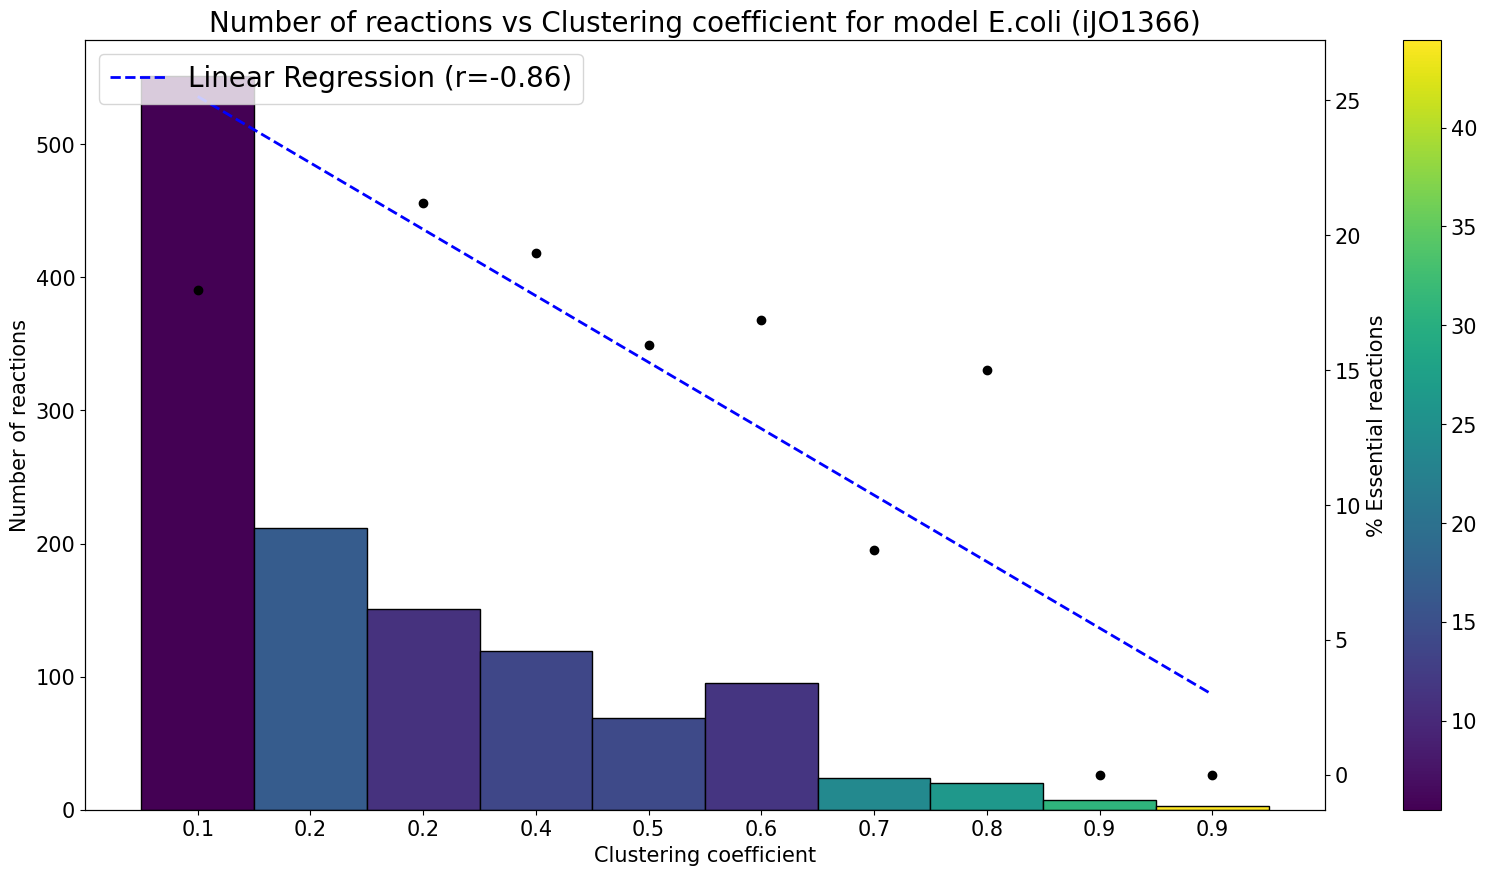

In [17]:
#clustering coefficient
clustering_coefficient = get_clustering_coefficient(model_graph_df)
clustering_coefficient_values = list(clustering_coefficient.values())

bins = np.linspace(min(clustering_coefficient_values), max(clustering_coefficient_values), num=11)
hist_data, bin_edges = np.histogram(clustering_coefficient_values, bins=bins)
essential_reactions_percentage = []
for bin_start, bin_end in zip(bin_edges[:-1], bin_edges[1:]):
    # Find reactions within this bin
    in_bin = [reaction for reaction, value in clustering_coefficient.items() if bin_start <= value < bin_end]
    # Count how many of these are essential
    essential_in_bin = sum(reaction in Essential_reactions for reaction in in_bin)
    # Calculate percentage
    total_in_bin = len(in_bin)
    percentage = (essential_in_bin / total_in_bin * 100) if total_in_bin > 0 else 0
    essential_reactions_percentage.append(percentage)

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
fig, ax1 = plt.subplots(figsize=(20, 10))
ax1.bar(bin_edges[:-1], hist_data, width=np.diff(bin_edges), color=colors, edgecolor='black', align='edge')
ax2 = ax1.twinx()
ax2.scatter(bin_centers, essential_reactions_percentage, color='black', zorder=5)
slope, intercept, r_value, p_value, std_err = linregress(bin_centers, essential_reactions_percentage)
x_reg_values = np.linspace(min(bin_centers), max(bin_centers), 100)
y_reg_values = slope * x_reg_values + intercept
ax2.plot(x_reg_values, y_reg_values, color='blue', linestyle='--', linewidth=2, label=f'Linear Regression (r={r_value:.2f})')
ax1.set_xlabel('Clustering coefficient')
ax1.set_ylabel('Number of reactions', color='black')
ax2.set_ylabel('% Essential reactions', color='black')
ax1.set_title('Number of reactions vs Clustering coefficient for model ' + model_name, fontsize=20)
ax2.legend(loc='upper left', fontsize=20)
ax1.set_xticks(bin_centers)
ax1.set_xticklabels([f"{center:.1f}" for center in bin_centers])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax1, orientation='vertical')
plt.rcParams.update({'font.size': 15})
plt.show()


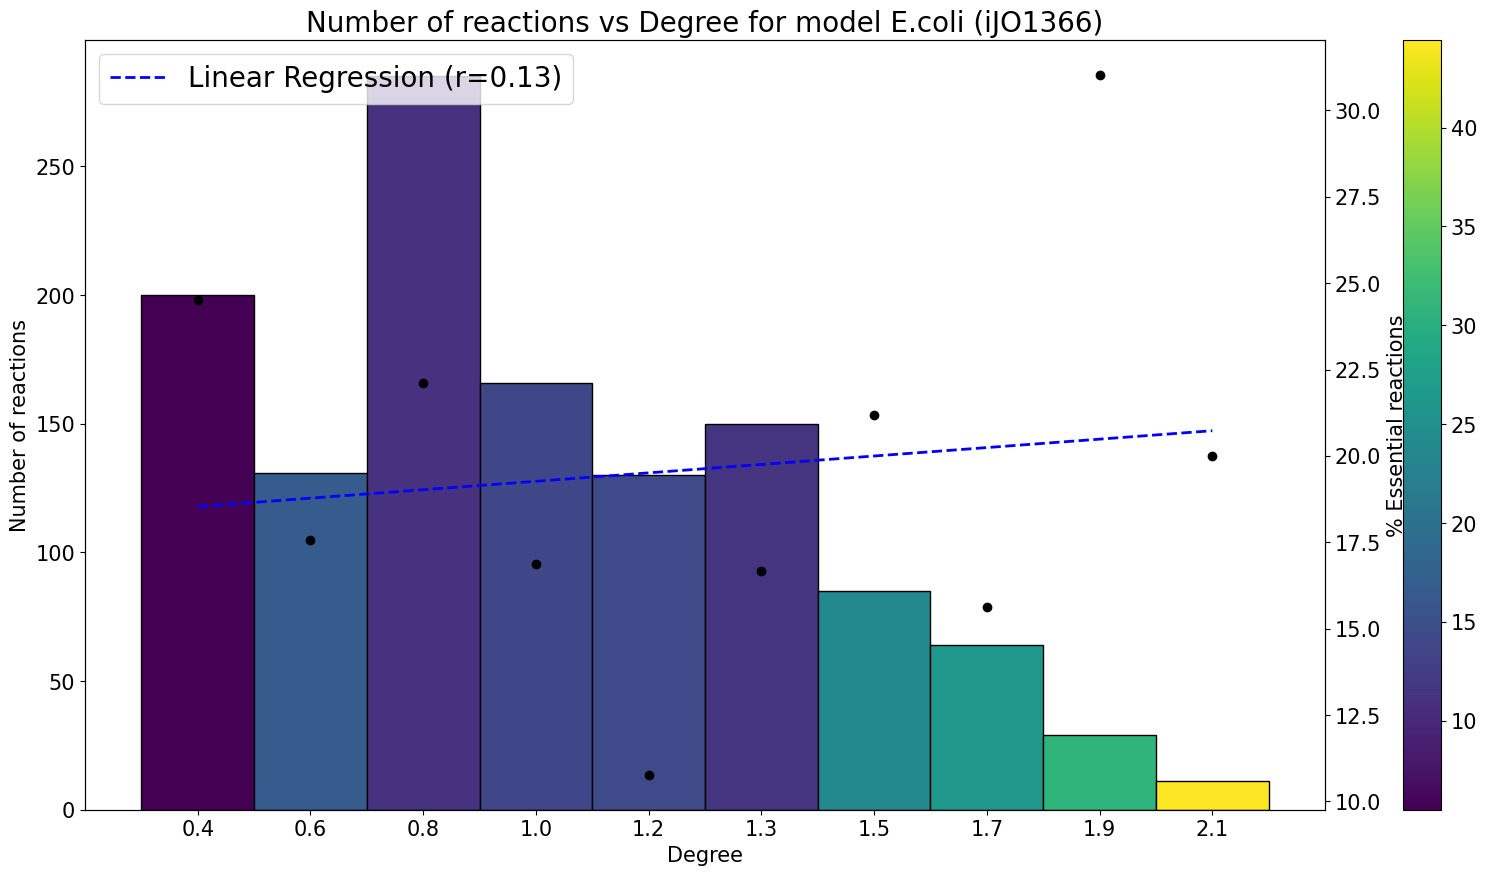

In [18]:
#degree
degree = get_degree(model_graph_df)
degree_values = list(degree.values())

bins = np.linspace(min(degree_values), max(degree_values), num=11)
hist_data, bin_edges = np.histogram(degree_values, bins=bins)
essential_reactions_percentage = []
for bin_start, bin_end in zip(bin_edges[:-1], bin_edges[1:]):
    # Find reactions within this bin
    in_bin = [reaction for reaction, value in degree.items() if bin_start <= value < bin_end]
    # Count how many of these are essential
    essential_in_bin = sum(reaction in Essential_reactions for reaction in in_bin)
    # Calculate percentage
    total_in_bin = len(in_bin)
    percentage = (essential_in_bin / total_in_bin * 100) if total_in_bin > 0 else 0
    essential_reactions_percentage.append(percentage)

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
fig, ax1 = plt.subplots(figsize=(20, 10))
ax1.bar(bin_edges[:-1], hist_data, width=np.diff(bin_edges), color=colors, edgecolor='black', align='edge')
ax2 = ax1.twinx()
ax2.scatter(bin_centers, essential_reactions_percentage, color='black', zorder=5)
slope, intercept, r_value, p_value, std_err = linregress(bin_centers, essential_reactions_percentage)
x_reg_values = np.linspace(min(bin_centers), max(bin_centers), 100)
y_reg_values = slope * x_reg_values + intercept
ax2.plot(x_reg_values, y_reg_values, color='blue', linestyle='--', linewidth=2, label=f'Linear Regression (r={r_value:.2f})')
ax1.set_xlabel('Degree')
ax1.set_ylabel('Number of reactions', color='black')
ax2.set_ylabel('% Essential reactions', color='black')
ax1.set_title('Number of reactions vs Degree for model ' + model_name, fontsize=20)
ax2.legend(loc='upper left', fontsize=20)
ax1.set_xticks(bin_centers)
ax1.set_xticklabels([f"{center:.1f}" for center in bin_centers])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax1, orientation='vertical')
plt.rcParams.update({'font.size': 15})
plt.show()
